In [1]:
%reset -f
#import sparg_with_inf as sparg
import sys
sys.path.append("/home/puneeth/UofT/SpARG Project/sparg2.0-manuscript/sparg2.0")
import sparg as sparg
import tskit
import msprime
import numpy as np
import warnings
import matplotlib.pyplot as plt
from importlib import reload

reload(sparg)
warnings.simplefilter("always")

def locate_nodes(nodes, SpARG):
    """Calculate the location of the list of nodes

    Parameters
    ----------
    nodes : list
        List of nodes for which the locations will be calculated
    SpARG : SpatialARG
    	An instance of the SpatialARG class defined below. 

    Returns
    -------
    node_locations : dict
        The keys are the nodes. The values are the geographic location of the nodes in n dimensions
    variance_in_node_locations : dict
        The keys are the nodes. The values are the variance in the geographic location of the nodes in n dimensions
    """

    sigma = SpARG.dispersal_rate_matrix
    paths = SpARG.paths
    inverted_cov_mat = SpARG.inverted_paths_shared_time_matrix
    sample_locs_to_root_locs = SpARG.path_dispersal_distances
    root_locations = SpARG.root_locations
    node_shared_times = SpARG.node_paths_shared_times
    node_paths = SpARG.node_paths
    ts = SpARG.ts
    
    location_of_nodes = {} 
    variance_in_node_locations = {} 
    
    for i,node in enumerate(nodes): 
        node_specific_sharing = node_shared_times[node,:].copy()
        matmul_prod = np.matmul(node_specific_sharing, inverted_cov_mat)
        root_location = root_locations[node_paths[node][-1]]
        node_location = root_location + np.matmul(matmul_prod, sample_locs_to_root_locs)
        location_of_nodes[node] = node_location
        
        base_variance = np.matmul(matmul_prod, np.transpose(node_specific_sharing))
        ones = np.ones(inverted_cov_mat.shape[0])
        correction_denominator = np.matmul(np.matmul(np.transpose(ones),inverted_cov_mat),ones)
        correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
        corrected_variance_scaling_factor = (ts.max_root_time-ts.node(node).time)-base_variance+(correction_numerator/correction_denominator)
        total_variance_node = sigma*corrected_variance_scaling_factor
        variance_in_node_locations[node] = total_variance_node
    return location_of_nodes, variance_in_node_locations



def average_dispersal_treewise(ts, locations_of_nodes):
    branch_lengths = ts.tables.nodes.time[ts.tables.edges.parent] - ts.tables.nodes.time[ts.tables.edges.child]
    child_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.child) ))
    parent_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.parent) ))
    branch_distances = parent_locations - child_locations 
    ts_trees = ts.aslist()
    dispersal_rate = []
    average_dispersal_rate = []
    for ts_tree in ts_trees:     
        edge_ind = ts_tree.edge_array[ts_tree.edge_array>-1]
        tree_branch_lengths = branch_lengths[edge_ind]
        tree_branch_distances = branch_distances[edge_ind]
        tree_dispersal_rate = [ np.matmul( np.transpose([tree_branch_distances[i]]),[tree_branch_distances[i]] )/tree_branch_lengths[i] for i in range(len(tree_branch_distances)) ]
        tree_dispersal_rate = np.sum(np.array(tree_dispersal_rate), axis=0)/ts.num_samples   
        dispersal_rate += [tree_dispersal_rate]
        average_dispersal_rate += [ np.average(np.array(dispersal_rate), axis=0) ]
    return dispersal_rate, average_dispersal_rate 

In [37]:
ts = tskit.load("slim_0.25rep1sigma.trees")

for sd in range(4):
    print(sd)
    np.random.seed(sd)
    keep_nodes = list(np.random.choice(ts.samples(), 100, replace=False))
    
    ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
    ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
    ts_chopped = sparg.chop_arg(ts_filtered,10000)
    FullARG = sparg.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
    locations_of_nodes, var_nodes = locate_nodes(nodes = range(ts_chopped.num_nodes), SpARG = FullARG)
    dispersal_rate_treewise, average_dispersal_rate_treewise = average_dispersal_treewise(ts=ts_chopped, locations_of_nodes = locations_of_nodes)
    print("Step")
    
    outfile = open("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_" + str(sd) +".txt", "w")
    i = 0
    ts_breaks = ts_chopped.breakpoints(as_array=True)
    print(len(ts_breaks))
    FI1_trees = []
    FI2_trees = []
    sigma_trees = [] 
    for (bp_i,bp) in enumerate(ts_breaks):
        if bp_i > 0:
             if bp_i%10 == 0 or bp_i == 1 :
                if bp_i in range(0,1551,100):
                    print(sd, bp_i)
                ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
                ts_short_sim, maps_short_sim = sparg.simplify_with_recombination(ts=ts_short)
                ts_short_attached = sparg.chop_arg(ts=ts_short, time = ts_short.max_time )
                
                print(sd, bp_i,ts_breaks[bp_i-1], bp)
                ts_tree = ts_short_attached.keep_intervals(intervals=[(ts_breaks[bp_i-1],bp)], simplify=False).trim() 
                ts_tree = sparg.chop_arg(ts=ts_tree,time= ts_tree.max_time)
                
                PartialARG = sparg.SpatialARG(ts=ts_short_attached,dimensions=2, verbose=False)
                dispersal_rate = PartialARG.dispersal_rate_matrix
                FI1 = PartialARG.inf_fishers_information_1
                FI2 = PartialARG.inf_fishers_information_2 
                loc_nodes, var_nodes = locate_nodes(nodes = range(ts_short_attached.num_nodes), SpARG = PartialARG)
                
                disp_ARG, avg_disp_ARG = average_dispersal_treewise(ts=ts_short_attached, locations_of_nodes = loc_nodes)
                
                Tree = sparg.SpatialARG(ts=ts_tree, dimensions=2, verbose=False)
                
                dispersal_rate_tree = Tree.dispersal_rate_matrix
                FI1_tree = Tree.fishers_information_1 
                FI2_tree = Tree.fishers_information_2
                               
                FI1_trees += [ dispersal_rate_tree[0][0]**2*FI1 ]
                FI2_trees += [ dispersal_rate_tree[0][0]**3*FI2 ]
                sigma_trees += [ dispersal_rate_tree[0][0] ]

                sigma_avg = np.average(sigma_trees)
                FI1_avg = np.sum(FI1_trees)/(sigma_avg**2)
                FI2_avg = np.sum(FI2_trees)/(sigma_avg**3)

                outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(dispersal_rate[0][0]) + " " + str(dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg) + " " + str(dispersal_rate_treewise[bp_i][0][0])+ " " + str(dispersal_rate_treewise[bp_i][1][1]) + " " + str(average_dispersal_rate_treewise[bp_i][0][0])+ " " + str(average_dispersal_rate_treewise[bp_i][1][1]) + " " + str(avg_disp_ARG[-1][0][0])+ " " + str(avg_disp_ARG[-1][1][1]) + "\n")
                
    outfile.close()

    

0
Step
1546
0 1 0.0 1459.0


/tmp/ipykernel_31712/1086868826.py:16: ResourceWarning: unclosed file <_io.TextIOWrapper name='slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_0.txt' mode='w' encoding='UTF-8'>
  outfile = open("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_" + str(sd) +".txt", "w")


0 10 6280.0 7383.0
0 20 12480.0 13566.0
0 30 16482.0 16602.0
0 40 20792.0 21091.0
0 50 26847.0 27782.0
0 60 34720.0 34826.0
0 70 44035.0 47359.0
0 80 52541.0 53742.0
0 90 55311.0 55610.0
0 100
0 100 63190.0 63489.0
0 110 68839.0 68870.0
0 120 72371.0 73190.0
0 130 80523.0 81401.0
0 140 85756.0 85988.0
0 150 93754.0 95401.0
0 160 104354.0 104981.0
0 170 110077.0 110542.0
0 180 120760.0 121147.0
0 190 125695.0 126360.0
0 200
0 200 130828.0 131858.0
0 210 135743.0 137387.0


KeyboardInterrupt: 

In [5]:
ts = tskit.load("slim_0.25rep1sigma.trees")

for sd in range(1):
    print(sd)
    np.random.seed(sd)
    keep_nodes = list(np.random.choice(ts.samples(), 100, replace=False))
    
    ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
    ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
    ts_chopped = sparg.chop_arg(ts_filtered,10000)
    FullARG = sparg.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
    locations_of_nodes, var_nodes = locate_nodes(nodes = range(ts_chopped.num_nodes), SpARG = FullARG)
    dispersal_rate_treewise, average_dispersal_rate_treewise = average_dispersal_treewise(ts=ts_chopped, locations_of_nodes = locations_of_nodes)
    print("Step")
    
    outfile = open("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_" + str(sd) +".txt", "w")
    i = 0
    ts_breaks = ts_chopped.breakpoints(as_array=True)
    print(len(ts_breaks))
    FI1_trees = []
    FI2_trees = []
    sigma_trees = [] 
    for (bp_i,bp) in enumerate(ts_breaks):
        if bp_i > 0:
             if bp_i%10 == 0 or bp_i == 1 :
                if bp_i in range(0,1551,100):
                    print(sd, bp_i)
                ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
                ts_short_sim, maps_short_sim = sparg.simplify_with_recombination(ts=ts_short)
                ts_short_attached = sparg.chop_arg(ts=ts_short, time = ts_short.max_time )
                
                print(sd, bp_i,ts_breaks[bp_i-1], bp)
                ts_tree = ts_short_attached.keep_intervals(intervals=[(ts_breaks[bp_i-1],bp)], simplify=False).trim() 
                ts_tree = sparg.chop_arg(ts=ts_tree,time= ts_tree.max_time)
                
                PartialARG = sparg.SpatialARG(ts=ts_short_attached,dimensions=2, verbose=False)
                dispersal_rate = PartialARG.dispersal_rate_matrix
                FI1 = PartialARG.fishers_information_1
                FI2 = PartialARG.fishers_information_2 
                loc_nodes, var_nodes = locate_nodes(nodes = range(ts_short_attached.num_nodes), SpARG = PartialARG)
                
                disp_ARG, avg_disp_ARG = average_dispersal_treewise(ts=ts_short_attached, locations_of_nodes = loc_nodes)
                
                Tree = sparg.SpatialARG(ts=ts_tree, dimensions=2, verbose=False)
                
                dispersal_rate_tree = Tree.dispersal_rate_matrix
                FI1_tree = Tree.fishers_information_1 
                FI2_tree = Tree.fishers_information_2
                               
                FI1_trees += [ dispersal_rate_tree[0][0]**2*FI1 ]
                FI2_trees += [ dispersal_rate_tree[0][0]**3*FI2 ]
                sigma_trees += [ dispersal_rate_tree[0][0] ]

                sigma_avg = np.average(sigma_trees)
                FI1_avg = np.sum(FI1_trees)/(sigma_avg**2)
                FI2_avg = np.sum(FI2_trees)/(sigma_avg**3)
                
                if bp_i > 21 and bp_i < len(ts_breaks)-21: 
                    W20_ts = ts_chopped.keep_intervals(intervals=[(ts_breaks[bp_i-21],ts_breaks[bp_i+20])], simplify=False).trim() 
                    W20_ts = sparg.chop_arg(ts=W20_ts,time= W20_ts.max_time)
                    W20_ARG = sparg.SpatialARG(ts=W20_ts, dimensions=2,verbose=False)
                    W20_disp = W20_ARG.dispersal_rate_matrix
                    loc_nodes, var_nodes = locate_nodes(nodes = range(W20_ts.num_nodes), SpARG = W20_ARG)
                    disp_W20_treewise, avg_disp_W20_treewise = average_dispersal_treewise(ts=W20_ts, locations_of_nodes = loc_nodes)
                    outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(dispersal_rate[0][0]) + " " + str(dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg) + " " + str(dispersal_rate_treewise[bp_i][0][0])+ " " + str(dispersal_rate_treewise[bp_i][1][1]) + " " + str(average_dispersal_rate_treewise[bp_i][0][0])+ " " + str(average_dispersal_rate_treewise[bp_i][1][1]) + " " + str(avg_disp_ARG[-1][0][0])+ " " + str(avg_disp_ARG[-1][1][1]) + " " +str(W20_disp[0][0]) + " " +str(W20_disp[1][1]) + " " + str(avg_disp_W20_treewise[-1][0][0]) + " " + str(avg_disp_W20_treewise[-1][1][1]) + "\n")
                else: 
                    outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(dispersal_rate[0][0]) + " " + str(dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg) + " " + str(dispersal_rate_treewise[bp_i][0][0])+ " " + str(dispersal_rate_treewise[bp_i][1][1]) + " " + str(average_dispersal_rate_treewise[bp_i][0][0])+ " " + str(average_dispersal_rate_treewise[bp_i][1][1]) + " " + str(avg_disp_ARG[-1][0][0])+ " " + str(avg_disp_ARG[-1][1][1]) + "\n")
                
    outfile.close()

0


KeyboardInterrupt: 

In [7]:
ts = tskit.load("slim_0.25rep1sigma.trees")

for sd in range(1):
    print(sd)
    np.random.seed(sd)
    keep_nodes = list(np.random.choice(ts.samples(), 10, replace=False))
    
    ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
    ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
    ts_chopped = sparg.chop_arg(ts_filtered,10000)
    FullARG = sparg.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
    locations_of_nodes, var_nodes = locate_nodes(nodes = range(ts_chopped.num_nodes), SpARG = FullARG)
    dispersal_rate_treewise, average_dispersal_rate_treewise = average_dispersal_treewise(ts=ts_chopped, locations_of_nodes = locations_of_nodes)
    print("Step")
    
    outfile = open("short_slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_" + str(sd) +".txt", "w")
    i = 0
    ts_breaks = ts_chopped.breakpoints(as_array=True)
    print(len(ts_breaks))
    FI1_trees = []
    FI2_trees = []
    sigma_trees = [] 
    for (bp_i,bp) in enumerate(ts_breaks):
        if bp_i > 0 and bp_i <100:
            print(sd, bp_i)
            ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
            ts_short_sim, maps_short_sim = sparg.simplify_with_recombination(ts=ts_short)
            ts_short_attached = sparg.chop_arg(ts=ts_short, time = ts_short.max_time )

            ts_tree = ts_short_attached.keep_intervals(intervals=[(ts_breaks[bp_i-1],bp)], simplify=False).trim() 
            ts_tree = sparg.chop_arg(ts=ts_tree,time= ts_tree.max_time)

            PartialARG = sparg.SpatialARG(ts=ts_short_attached,dimensions=2, verbose=False)
            dispersal_rate = PartialARG.dispersal_rate_matrix
            FI1 = PartialARG.fishers_information_1
            FI2 = PartialARG.fishers_information_2 
            loc_nodes, var_nodes = locate_nodes(nodes = range(ts_short_attached.num_nodes), SpARG = PartialARG)
            disp_ARG, avg_disp_ARG = average_dispersal_treewise(ts=ts_short_attached, locations_of_nodes = loc_nodes)
                
            Tree = sparg.SpatialARG(ts=ts_tree, dimensions=2, verbose=False)

            dispersal_rate_tree = Tree.dispersal_rate_matrix
            FI1_tree = Tree.fishers_information_1 
            FI2_tree = Tree.fishers_information_2

            FI1_trees += [ dispersal_rate_tree[0][0]**2*FI1 ]
            FI2_trees += [ dispersal_rate_tree[0][0]**3*FI2 ]
            sigma_trees += [ dispersal_rate_tree[0][0] ]

            sigma_avg = np.average(sigma_trees)
            FI1_avg = np.sum(FI1_trees)/(sigma_avg**2)
            FI2_avg = np.sum(FI2_trees)/(sigma_avg**3)

            if bp_i > 21 and bp_i < len(ts_breaks)-21: 
                W20_ts = ts_chopped.keep_intervals(intervals=[(ts_breaks[bp_i-21],ts_breaks[bp_i+20])], simplify=False).trim() 
                W20_ts = sparg.chop_arg(ts=W20_ts,time= W20_ts.max_time)
                W20_ARG = sparg.SpatialARG(ts=W20_ts, dimensions=2,verbose=False)
                W20_disp = W20_ARG.dispersal_rate_matrix
                loc_nodes, var_nodes = locate_nodes(nodes = range(W20_ts.num_nodes), SpARG = W20_ARG)
                disp_W20_treewise, avg_disp_W20_treewise = average_dispersal_treewise(ts=W20_ts, locations_of_nodes = loc_nodes)
                outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(dispersal_rate[0][0]) + " " + str(dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg) + " " + str(dispersal_rate_treewise[bp_i][0][0])+ " " + str(dispersal_rate_treewise[bp_i][1][1]) + " " + str(average_dispersal_rate_treewise[bp_i][0][0])+ " " + str(average_dispersal_rate_treewise[bp_i][1][1]) + " " + str(avg_disp_ARG[-1][0][0])+ " " + str(avg_disp_ARG[-1][1][1]) + " " +str(W20_disp[0][0]) + " " +str(W20_disp[1][1]) + " " + str(avg_disp_W20_treewise[-1][0][0]) + " " + str(avg_disp_W20_treewise[-1][1][1]) + "\n")
            else: 
                outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(dispersal_rate[0][0]) + " " + str(dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg) + " " + str(dispersal_rate_treewise[bp_i][0][0])+ " " + str(dispersal_rate_treewise[bp_i][1][1]) + " " + str(average_dispersal_rate_treewise[bp_i][0][0])+ " " + str(average_dispersal_rate_treewise[bp_i][1][1]) + " " + str(avg_disp_ARG[-1][0][0])+ " " + str(avg_disp_ARG[-1][1][1]) + "\n")

outfile.close()

0
Step
595
0 1
0 2


/tmp/ipykernel_6955/410439789.py:16: ResourceWarning: unclosed file <_io.TextIOWrapper name='short_slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_0.txt' mode='w' encoding='UTF-8'>
  outfile = open("short_slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_" + str(sd) +".txt", "w")


0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99


In [ ]:
ts = tskit.load("slim_0.25rep1sigma.trees")

for sd in range(1):
    print(sd)
    np.random.seed(sd)
    keep_nodes = list(np.random.choice(ts.samples(), 10, replace=False))
    
    ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
    ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
    ts_chopped = sparg.chop_arg(ts_filtered,10000)
    #FullARG = sparg.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
    print("Step")
    
    outfile = open("slim_0.25rep1sigma_inf_dispersalrateestimates_seqlen_100_chopped_10000_rep_" + str(sd) +".txt", "w")
    i = 0
    ts_breaks = ts_chopped.breakpoints(as_array=True)
    print(len(ts_breaks))
    FI1_trees = []
    FI2_trees = []
    sigma_trees = [] 
    for (bp_i,bp) in enumerate(ts_breaks):
        if bp_i > 0 and bp_i < 100:
            print(sd, bp_i)
            ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
            ts_short_sim, maps_short_sim = sparg.simplify_with_recombination(ts=ts_short)
            ts_short_attached = sparg.chop_arg(ts=ts_short, time = ts_short.max_time )

            ts_tree = ts_short_attached.keep_intervals(intervals=[(ts_breaks[bp_i-1],bp)], simplify=False).trim() 
            ts_tree = sparg.chop_arg(ts=ts_tree,time= ts_tree.max_time)

            PartialARG = sparg.SpatialARG(ts=ts_short_attached,dimensions=2, verbose=False)
            inf_dispersal_rate = PartialARG.inf_dispersal_rate_matrix
            FI1 = PartialARG.inf_fishers_information_1
            FI2 = PartialARG.inf_fishers_information_2 

            Tree = sparg.SpatialARG(ts=ts_tree, dimensions=2, verbose=False)

            inf_dispersal_rate_tree = Tree.inf_dispersal_rate_matrix
            FI1_tree = Tree.inf_fishers_information_1 
            FI2_tree = Tree.inf_fishers_information_2

            FI1_trees += [ inf_dispersal_rate_tree[0][0]**2*FI1 ]
            FI2_trees += [ inf_dispersal_rate_tree[0][0]**3*FI2 ]
            sigma_trees += [ inf_dispersal_rate_tree[0][0] ]

            sigma_avg = np.average(sigma_trees)
            FI1_avg = np.sum(FI1_trees)/(sigma_avg**2)
            FI2_avg = np.sum(FI2_trees)/(sigma_avg**3)

            outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(inf_dispersal_rate[0][0]) + " " + str(inf_dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg)  + "\n")
                
                
    outfile.close()

0
Step
595
0 1
0 100
0 100


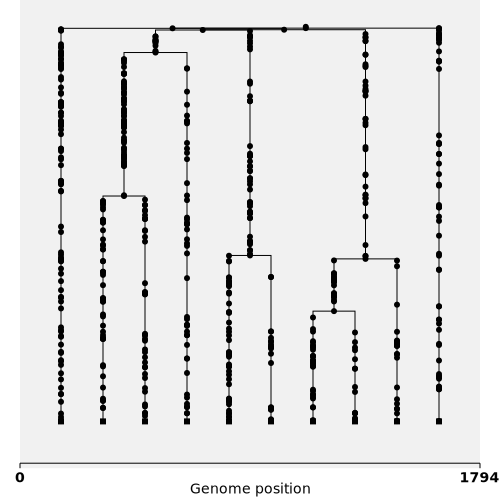

In [39]:
ts_short_attached.draw_svg(size = (500,500), node_labels={})

In [17]:
%matplotlib qt

dispersal_1 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_0.txt")

plt.plot(dispersal_1[:,0], dispersal_1[:,2], color='black', label = "ARG Likelihood")
#plt.plot(dispersal_1[:,0], dispersal_1[:,9], color = 'red', linestyle = "dashdot", label = "Average w/ Full ARG")
plt.plot(dispersal_1[:,0], dispersal_1[:,5], color = 'blue', linestyle = "--", label = "Comp Likelihood")
plt.plot(dispersal_1[:,0], dispersal_1[:,11], color = 'green', linestyle = "dotted", label = "Average (ARG)")
plt.plot(dispersal_1[3:len(dispersal_1[:,0])-2,0], dispersal_1[3:len(dispersal_1[:,0])-2,13], color = 'red', linestyle = "dotted", label = "W 20")

plt.axhline(y=0.25**2,label = "True Value", linestyle = '--', color = 'grey')
plt.axhline(y=0.25**2+0.5,label = "Effective Value", color = 'grey')

plt.legend()
plt.xlabel("Number of Trees", fontsize = 15)
plt.ylabel("Dispersal Estimate", fontsize = 15)
plt.show()

In [10]:
%matplotlib qt


dispersal_1 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_0.txt")

dispersal_2 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_1.txt")

dispersal_3 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_2.txt")

dispersal_4 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_3.txt")


plt.figure()

plt.plot(dispersal_1[:,0], np.sqrt(1/(np.array(dispersal_1[:,4])*np.array(dispersal_1[:,2])*np.array(dispersal_1[:,2]))), color = 'red' ) 
plt.plot(dispersal_1[:,0], np.sqrt(1/(np.array(dispersal_1[:,6])*np.array(dispersal_1[:,5])*np.array(dispersal_1[:,5]))), linestyle= '--', color ='red' ) 

plt.plot(dispersal_2[:,0], np.sqrt(1/(np.array(dispersal_2[:,4])*np.array(dispersal_2[:,2])*np.array(dispersal_2[:,2]))), color ='blue' ) 
plt.plot(dispersal_2[:,0], np.sqrt(1/(np.array(dispersal_2[:,6])*np.array(dispersal_2[:,5])*np.array(dispersal_2[:,5]))), linestyle= '--', color ='blue' ) 

plt.plot(dispersal_3[:,0], np.sqrt(1/(np.array(dispersal_3[:,4])*np.array(dispersal_3[:,2])*np.array(dispersal_3[:,2]))), color = 'orange' ) 
plt.plot(dispersal_3[:,0], np.sqrt(1/(np.array(dispersal_3[:,6])*np.array(dispersal_3[:,5])*np.array(dispersal_3[:,5]))), linestyle= '--', color ='orange' ) 

plt.plot(dispersal_4[:,0], np.sqrt(1/(np.array(dispersal_4[:,4])*np.array(dispersal_4[:,2])*np.array(dispersal_4[:,2]))), color ='green' ) 
plt.plot(dispersal_4[:,0], np.sqrt(1/(np.array(dispersal_4[:,6])*np.array(dispersal_4[:,5])*np.array(dispersal_4[:,5]))), linestyle= '--', color ='green' ) 

plt.xlabel("Number of Trees", fontsize = 20)
plt.ylabel("Coefficient of Variantion", fontsize = 20)
plt.show()

plt.figure()


plt.plot(dispersal_1[:,0], np.sqrt(1/(np.array(dispersal_1[:,4])*np.array(dispersal_1[:,2])*np.array(dispersal_1[:,2]))), color = 'red' ) 
plt.plot(dispersal_1[:,0], np.sqrt(1/(np.array(dispersal_1[:,6])*np.array(dispersal_1[:,5])*np.array(dispersal_1[:,5]))), linestyle= '--', color ='red' ) 

plt.plot(dispersal_2[:,0], np.sqrt(1/(np.array(dispersal_2[:,4])*np.array(dispersal_2[:,2])*np.array(dispersal_2[:,2]))), color ='blue' ) 
plt.plot(dispersal_2[:,0], np.sqrt(1/(np.array(dispersal_2[:,6])*np.array(dispersal_2[:,5])*np.array(dispersal_2[:,5]))), linestyle= '--', color ='blue' ) 

plt.plot(dispersal_3[:,0], np.sqrt(1/(np.array(dispersal_3[:,4])*np.array(dispersal_3[:,2])*np.array(dispersal_3[:,2]))), color = 'orange' ) 
plt.plot(dispersal_3[:,0], np.sqrt(1/(np.array(dispersal_3[:,6])*np.array(dispersal_3[:,5])*np.array(dispersal_3[:,5]))), linestyle= '--', color ='orange' ) 

plt.plot(dispersal_4[:,0], np.sqrt(1/(np.array(dispersal_4[:,4])*np.array(dispersal_4[:,2])*np.array(dispersal_4[:,2]))), color ='green' ) 
plt.plot(dispersal_4[:,0], np.sqrt(1/(np.array(dispersal_4[:,6])*np.array(dispersal_4[:,5])*np.array(dispersal_4[:,5]))), linestyle= '--', color ='green' ) 

plt.xlabel("Number of Trees", fontsize = 20)
plt.ylabel("Coefficient of Variantion", fontsize = 20)
plt.show()

plt.ylim([0.127, 0.134])


"""
plt.plot(dispersal_1[:,0], dispersal_1[:,5])
plt.plot(dispersal_2[:,0], dispersal_2[:,5])
plt.plot(dispersal_3[:,0], dispersal_3[:,5])
plt.plot(dispersal_4[:,0], dispersal_4[:,5])
plt.xlabel("Number of Trees")
plt.ylabel("Dispersal Estimate - Rnk")
plt.show()

plt.plot(dispersal_1[:,0], 1/dispersal_1[:,7])
plt.plot(dispersal_2[:,0], 1/dispersal_2[:,7])
plt.plot(dispersal_3[:,0], 1/dispersal_3[:,7])
plt.plot(dispersal_4[:,0], 1/dispersal_4[:,7])
plt.xlabel("Number of Treees")
plt.ylabel("Inverse of Fisher Info Index - Rnk")
plt.show()
"""

'\nplt.plot(dispersal_1[:,0], dispersal_1[:,5])\nplt.plot(dispersal_2[:,0], dispersal_2[:,5])\nplt.plot(dispersal_3[:,0], dispersal_3[:,5])\nplt.plot(dispersal_4[:,0], dispersal_4[:,5])\nplt.xlabel("Number of Trees")\nplt.ylabel("Dispersal Estimate - Rnk")\nplt.show()\n\nplt.plot(dispersal_1[:,0], 1/dispersal_1[:,7])\nplt.plot(dispersal_2[:,0], 1/dispersal_2[:,7])\nplt.plot(dispersal_3[:,0], 1/dispersal_3[:,7])\nplt.plot(dispersal_4[:,0], 1/dispersal_4[:,7])\nplt.xlabel("Number of Treees")\nplt.ylabel("Inverse of Fisher Info Index - Rnk")\nplt.show()\n'